Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, precision_score, roc_auc_score,accuracy_score, f1_score
from catboost import CatBoostClassifier as cat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import shap
shap.initjs()

In [19]:
df = pd.read_csv('heart.csv')
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Attribute Information

1) age - age
2) sex - sex
3) cp - chest pain type (4 values)
4) trestbps - resting blood pressure
5) chol - serum cholestoral in mg/dl
6) fbs - fasting blood sugar > 120 mg/dl
7) restecg - resting electrocardiographic results (values 0,1,2)
8) thalach - maximum heart rate achieved
9) exang - exercise induced angina
10) oldpeak - oldpeak = ST depression induced by exercise relative to rest
11) slope - the slope of the peak exercise ST segment
12) ca - number of major vessels (0-3) colored by flourosopy
13) thal - A blood disorder called thalassemia: 0 = normal; 1 = fixed defect; 2 = reversable defect
14) target - target: 0= less chance of heart attack 1= more chance of heart attack

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [21]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [23]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [24]:
scale = ['trestbps', 'chol', 'thalach', 'exang']

In [25]:
y = df['target']
X = df.drop(columns=['target'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
scaler = StandardScaler()
X_train[scale] = scaler.fit_transform(X_train[scale])
X_test[scale] = scaler.transform(X_test[scale])

In [28]:
feats = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
         'exang', 'oldpeak', 'slope', 'ca', 'thal']

13

In [29]:
corr = df.corr()
corr.style.background_gradient()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


Корреляция между признаками выражена слабо, особо заметна между:

age - resting blood pressure
age - number of major vessels
chest pain type - maximum heart rate achieved
maximum heart rate achieved - slope
excercise induced angina - oldpeak

Целевое значение зависит от:
chest pain type
maximum heart rate achieved
slope

In [30]:
model = cat(silent=True)

model.fit(X_train, y_train)
preds = model.predict(X_test)

In [31]:
def metrics(y_test, preds):
    precision = precision_score(y_test, preds, average='binary')
    recall = recall_score(y_test, preds, average='binary')
    roc_auc = roc_auc_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    f_score = f1_score(y_test, preds)

    values = {'precision': precision,
              'recall': recall,
              'roc_auc': roc_auc,
              'accuracy': accuracy,
              'F-score': f_score}
    return values

In [32]:
results = pd.DataFrame(columns=['model', 'f1', 'roc_auc', 'recall', 'precision'])

In [33]:
results = pd.DataFrame(metrics(y_test, preds), index=[0])
results

,precision,recall,roc_auc,accuracy,F-score
0,0.844828,0.844828,0.815271,0.82,0.844828


In [34]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

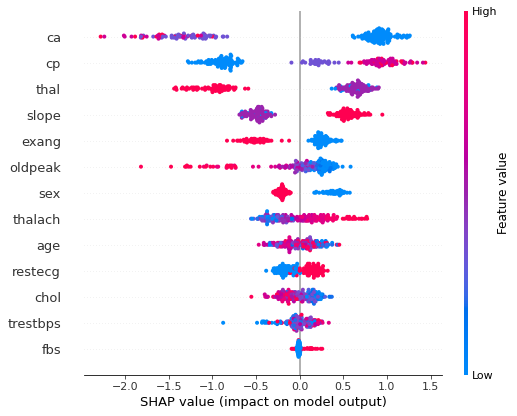

In [36]:
shap.summary_plot(shap_values, X_train)

Из графика можно сделать следующие выводы:
Меньшее количество крупных сосудов, наличие грудных болей 4-го типа и высокое значение параметра slope повышают риск сердечного приступа.
Достаточно странно наблюдать влияние на риск сердечного приступа значения таласемии, так как высокое влияние на риск сердечного приступа оказывают значения "норма" и "обратимые дефекты".
Так же более высокое значение достигнутой максимальной ЧСС напрямую влияет на риск приступа, возможно связано с зафиксированными случаями во время тестирования.

In [41]:
shap_sum = []
for i in shap_values:
    shap_sum.append(i.sum())


In [42]:
X_train['shap_sum'] = shap_sum

In [51]:
top10 = X_train.sort_values(by='shap_sum', ascending=False)[:round(len(X_train)*0.1)]
top10

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,shap_sum
115,37,0,2,-0.634945,-0.609517,0,1,0.899556,-0.701888,0.0,2,0,2,4.548040
38,65,0,2,1.420310,0.374507,0,1,-0.073184,-0.701888,0.8,2,0,2,4.170428
156,47,1,2,-0.047729,0.082945,0,1,1.297496,-0.701888,0.0,2,0,2,4.081349
36,54,0,2,0.245879,1.012301,1,1,0.899556,-0.701888,0.0,2,0,2,4.081097
44,39,1,2,0.539486,1.322087,0,0,1.430142,-0.701888,0.0,2,0,2,3.994230
162,41,1,1,-0.634945,-1.666433,0,1,1.430142,-0.701888,0.0,2,0,2,3.984407
142,42,0,2,-0.634945,-0.718853,0,1,1.032203,-0.701888,0.0,1,0,2,3.974991
147,60,0,3,1.126702,-0.153950,0,1,0.943772,-0.701888,0.9,2,0,2,3.953014
74,43,0,2,-0.517502,-0.645963,0,1,0.678479,-0.701888,0.2,1,0,2,3.935675
157,35,1,1,-0.517502,-1.028639,0,1,1.076418,-0.701888,0.0,2,0,2,3.934237


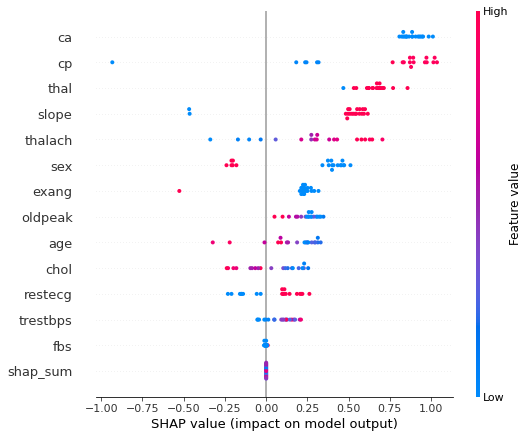

In [52]:
shap_values_top = explainer.shap_values(top10)
shap.summary_plot(shap_values_top, top10)

In [70]:
shap.force_plot(explainer.expected_value, shap_values_top[2,:], top10.iloc[2,:-1])

Не очень понятно как интерпретировать этот график. Он должен показывать вклад каждого наблюдения в предсказание для определенной строчки. Из графика выше получается, что результаты кардиограммы в покое имели наивысший вклад.